#### Step 3.1: Setting Up the Modeling Notebook

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the model and scaler

In [2]:
# Scikit-learn for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Scikit-learn for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# Scikit-learn for evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set style for plots
sns.set_style('whitegrid')

In [5]:
# Cell 2: Load Data
df = pd.read_csv('data/crm_data.csv')

# Display a sample to verify
df.head()

,CustomerID,Age,Gender,Location,SubscriptionTier,Tenure,MonthlyRevenue,UsageFrequency,SupportTickets,LastInteraction,Churn
0,539437dc-664b-480c-9937-790233cc3ce9,27,Male,Houston,Premium,39,109.62,66,2,17,0
1,528c42a3-b6a1-45df-913d-b2ecc0ac021b,60,Female,New York,Premium,60,108.37,108,0,35,0
2,f653e6b1-ed4b-4d26-b5e0-0bbf32f6a476,60,Male,San Jose,Premium,59,137.84,81,0,14,0
3,6217dde2-65c5-4620-9454-9877fbc55439,51,Male,Dallas,Basic,14,24.09,19,0,4,0
4,e13935ce-0394-4476-93c2-cb38ca14741a,60,Female,New York,Premium,54,87.08,98,0,57,0


#### Step 3.2: Data Preprocessing
Raw data is not suitable for machine learning models. We need to convert it into a purely numerical format.

This involves three key steps:

* Separating our features (X) from our target variable (y).
* Converting categorical text features into numbers (One-Hot Encoding).
* Scaling numerical features so they are on a similar scale.

#### Defining Features (X) and Target (y).

In [6]:
# Cell 3: Separate Features and Target
# The CustomerID is a unique identifier, not a predictive feature, so we drop it.
X = df.drop(['Churn', 'CustomerID'], axis=1)
y = df['Churn']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (10000, 9)
Shape of y: (10000,)


#### Split data into Training and Testing sets.

This is the most fundamental step to ensure we can evaluate our model's performance on data it has never seen before.

In [7]:
# Cell 4: Split the data
# We use stratify=y to ensure the proportion of churned customers is the same in train and test sets.
# This is crucial for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (8000, 9)
Testing set shape: (2000, 9)


* Why do we do this?

We train the model on the _train data and then test its real-world performance on the _test data. The random_state=42 ensures that we get the same split every time we run the code, making our results reproducible.

#### Create a Preprocessing Pipeline.

We'll use Scikit-learn's Pipeline and ColumnTransformer to create an elegant and robust preprocessing workflow. This bundles all our steps together.

In [8]:
# Cell 5: Create Preprocessing Pipeline
# Identify categorical and numerical features
categorical_features = ['Gender', 'Location', 'SubscriptionTier']
numerical_features = ['Age', 'Tenure', 'MonthlyRevenue', 'UsageFrequency', 'SupportTickets', 'LastInteraction']

# Create the preprocessing pipelines for both numerical and categorical data
# For numerical data, we'll scale it.
# For categorical data, we'll one-hot encode it.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Let's see what the preprocessor does
# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) # IMPORTANT: Only transform the test data

print("Shape of processed training data:", X_train_processed.shape)
print("Shape of processed testing data:", X_test_processed.shape)

Shape of processed training data: (8000, 21)
Shape of processed testing data: (2000, 21)


* Why a pipeline?

* Automation: It combines multiple steps into one.
Prevents Data Leakage: By fitting the StandardScaler only on the training data and then using it to transform both train and test data, we prevent any information from the test set from "leaking" into our training process.
* Reproducibility: It ensures the exact same transformations are applied every time.

Notice the shape of the processed data has more columns. This is because OneHotEncoder created new columns for each category (e.g., Location_New York, Location_Chicago, etc.).

#### Step 3.3: Model Training

We'll train two models:

* Logistic Regression: A simple, interpretable model that will serve as our baseline.
* Gradient Boosting: A powerful and popular ensemble model that is often a top performer on tabular data.

In [9]:
# Cell 6: Train Models
# We will create full pipelines that include the preprocessor and the model
# This makes it easy to use the model later on raw data

In [10]:
# --- Model 1: Logistic Regression (Baseline) ---
# We use class_weight='balanced' to help the model deal with the imbalanced data
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(class_weight='balanced', random_state=42))])

print("Training Logistic Regression model...")
pipeline_lr.fit(X_train, y_train)
print("Training complete.")

Training Logistic Regression model...
Training complete.


In [11]:
# --- Model 2: Gradient Boosting (Advanced) ---
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

print("\nTraining Gradient Boosting model...")
pipeline_gb.fit(X_train, y_train)
print("Training complete.")


Training Gradient Boosting model...
Training complete.


#### Step 3.4: Model Evaluation
How good are our models? We need to use the right metrics. For an imbalanced problem like churn, accuracy is not enough. We need to look at precision, recall, and the AUC score.

* Precision: Of all the customers we predicted would churn, how many actually did? (High precision means we don't bother happy customers).
* Recall: Of all the customers who actually churned, how many did we catch? (High recall means we don't miss at-risk customers).

In [12]:
# Cell 7: Make predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_gb = pipeline_gb.predict(X_test)

In [13]:
# Cell 8: Evaluate Models with Classification Report
print("--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_lr))

print("\n\n--- Gradient Boosting Report ---")
print(classification_report(y_test, y_pred_gb))

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1700
           1       0.38      0.88      0.53       300

    accuracy                           0.77      2000
   macro avg       0.68      0.81      0.69      2000
weighted avg       0.88      0.77      0.80      2000



--- Gradient Boosting Report ---
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1700
           1       0.64      0.16      0.25       300

    accuracy                           0.86      2000
   macro avg       0.75      0.57      0.59      2000
weighted avg       0.83      0.86      0.82      2000



##### Interpreting the Output:
* Looking at the above reuslts, specifically the lines for class 1 (Churn). 
* We see that the Gradient Boosting model has a better F1-score, which is a balanced measure of precision and recall. 
* For churn prediction, we often care more about Recall for class 1 — we'd rather mistakenly flag a happy customer (a false positive) than miss a customer who is about to leave (a false negative). The Gradient Boosting model should be superior here.

#### Visualize the Confusion Matrix and ROC Curve for our best model.

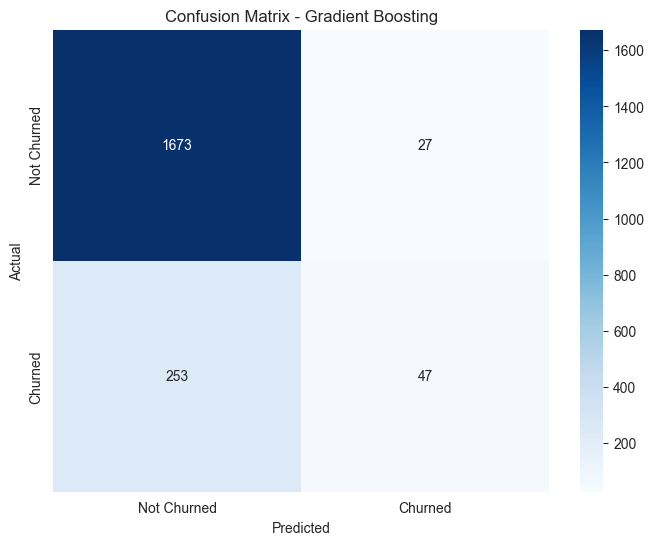

In [14]:
# Cell 9: Confusion Matrix for Gradient Boosting
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

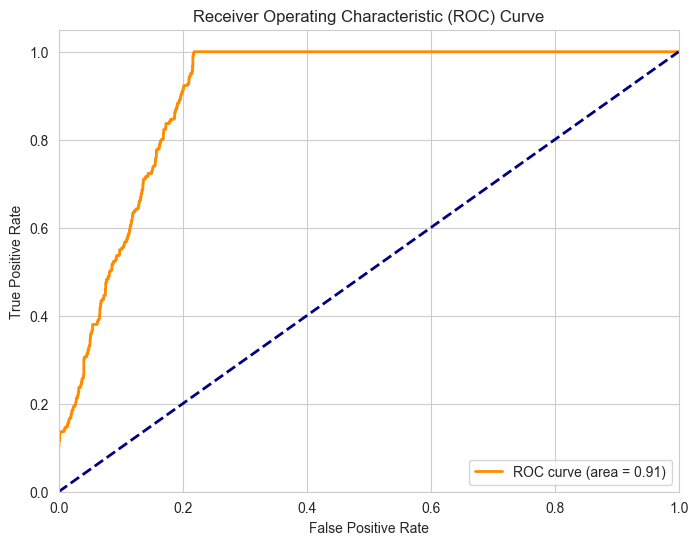

AUC Score for Gradient Boosting: 0.9052


In [15]:
# Cell 10: ROC Curve and AUC Score
y_prob_gb = pipeline_gb.predict_proba(X_test)[:, 1] # Get probabilities for the positive class
auc_score = roc_auc_score(y_test, y_prob_gb)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score for Gradient Boosting: {auc_score:.4f}")

The AUC score gives us a single number to represent the model's overall ability to distinguish between churners and non-churners. A score close to 1.0 is excellent. Our Gradient Boosting model should achieve a score well above 0.5.

#### Step 3.5: Feature Importance
Let's ask our best model (Gradient Boosting) which features it found most important for making its predictions.

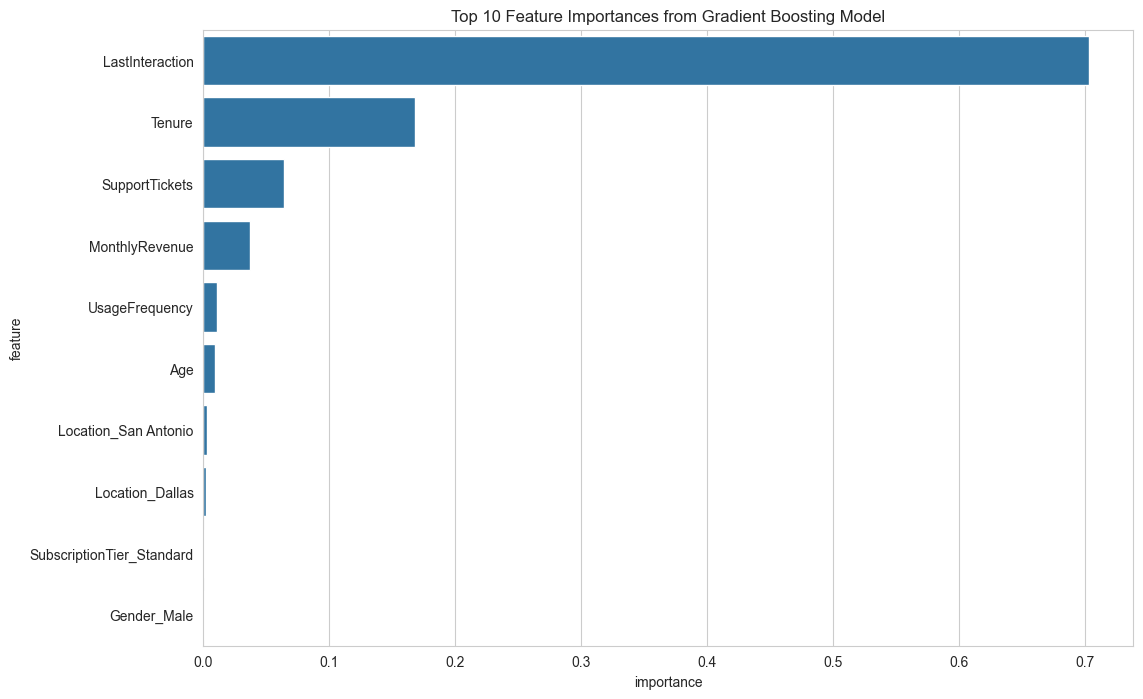

In [16]:
# Cell 11: Get Feature Importances
# We need to get the feature names after one-hot encoding
ohe_feature_names = pipeline_gb.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

importances = pipeline_gb.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10)) # Top 10 features
plt.title('Top 10 Feature Importances from Gradient Boosting Model')
plt.show()

This bar chart is incredibly valuable. It will visually confirm what we suspected during EDA: UsageFrequency, Tenure, and LastInteraction are likely to be the most powerful predictors of churn. This provides business users with actionable insights.

#### Step 3.6: Saving the Final Model
We've selected our best model: the Gradient Boosting pipeline. Now, we must save it to disk so we can use it in our production system without having to retrain it every time.

#### Create a models folder and save the pipeline.

In [17]:
# Cell 12: Save the final model pipeline
# We are saving the entire pipeline (preprocessor + model)
# This makes it easy to use for future predictions on raw data
model_path = 'models/churn_model_pipeline.joblib'
joblib.dump(pipeline_gb, model_path)

print(f"Model pipeline saved to: {model_path}")

Model pipeline saved to: models/churn_model_pipeline.joblib


This file contains our entire trained workflow, ready to be deployed

In [26]:
import os
# This will get the full, unambiguous path to your project directory
# We'll use this to create an absolute path to our mlruns folder
project_path = os.getcwd()
mlruns_path = os.path.join(project_path, "mlruns")

# The format needs to be a URI (file:///)
# On Windows, we need to make sure the slashes are correct
mlruns_uri = "file:///" + mlruns_path.replace("\\", "/")

print("Your absolute MLflow Tracking URI is:")
print(mlruns_uri)

Your absolute MLflow Tracking URI is:
file:///d:/Machine_learning/Projects/ai-customer-journey/mlruns


In [36]:
# Cell 13: Setup MLflow and AWS
import mlflow
import os
from dotenv import load_dotenv

# This function will find and load the variables from your .env file
load_dotenv()

# Check if the variables were loaded correctly
aws_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret = os.getenv("AWS_SECRET_ACCESS_KEY")

if not aws_key or not aws_secret:
    raise ValueError("AWS credentials not found. Make sure they are in your .env file.")
else:
    print("AWS credentials loaded successfully from .env file.")
    
# Paste your S3 bucket name
S3_BUCKET_NAME = 'ai-journey-mlflow-models-rnstud08'
# --- END CONFIGURATION ---

# Set the MLflow tracking URI to a local directory.
# MLflow will store experiment metadata locally and model artifacts on S3.
# mlflow.set_tracking_uri("file:///./mlruns")
mlflow.set_tracking_uri("mlruns")

# Set the S3 bucket as the artifact store
artifact_location = f"s3://{S3_BUCKET_NAME}/mlflow-artifacts"

AWS credentials loaded successfully from .env file.


In [37]:
# The Ultimate Training & Logging Cell (with all best practices)

import mlflow
from mlflow.models import infer_signature
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# --- BEST PRACTICE: Handle potential missing values in integer columns ---
# Convert integer columns to float64 to make the model signature more robust
print("Converting integer columns to float64 for robustness...")
int_cols = X.select_dtypes(include=['int64', 'int32']).columns
X[int_cols] = X[int_cols].astype('float64')

# Re-run train_test_split with the corrected dtype
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data types corrected.")
# ---

# Define the full pipeline
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

# Define an experiment name
experiment_name = "Churn_Prediction_Experiment"
mlflow.set_experiment(experiment_name)

print("\nStarting MLflow run to train and log the model...")
with mlflow.start_run(run_name="GradientBoosting_Robust_Run") as run:
    # Train the model
    pipeline_gb.fit(X_train, y_train)
    print("Model training complete.")
    
    # Evaluate the model
    y_prob_gb = pipeline_gb.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob_gb)
    print(f"Model AUC Score: {auc_score:.4f}")

    # Create the model signature
    input_example = X_train.head()
    signature = infer_signature(input_example, pipeline_gb.predict_proba(input_example))
    print("Model signature inferred successfully.")

    # Log artifacts to MLflow
    mlflow.log_params(pipeline_gb.named_steps['classifier'].get_params())
    mlflow.log_metric("roc_auc", auc_score)
    
    # Log the model with the signature and corrected parameter name
    print("Logging and registering the model to MLflow...")
    mlflow.sklearn.log_model(
        sk_model=pipeline_gb,
        artifact_path="churn_model", # This is the folder name in the run's artifacts
        signature=signature,
        input_example=input_example,
        registered_model_name="churn-predictor"
    )
    
    run_id = run.info.run_id
    print(f"\nMLflow Run ID: {run_id}")
    print(f"Model successfully saved to S3 and registered as 'churn-predictor'")

Converting integer columns to float64 for robustness...
Data types corrected.

Starting MLflow run to train and log the model...


2025/06/19 17:31:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model training complete.
Model AUC Score: 0.9052
Model signature inferred successfully.
Logging and registering the model to MLflow...

MLflow Run ID: b130552326bf45feb1562575f574d5a8
Model successfully saved to S3 and registered as 'churn-predictor'


Registered model 'churn-predictor' already exists. Creating a new version of this model...
Created version '3' of model 'churn-predictor'.


In [24]:
# AWS Connection Diagnostic Cell
import os
import boto3
from botocore.exceptions import NoCredentialsError, ClientError
from dotenv import load_dotenv

load_dotenv() # Load variables from .env

# Get credentials from environment
aws_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret = os.getenv("AWS_SECRET_ACCESS_KEY")
bucket_name = "ai-journey-mlflow-models-rnstud08" # <-- IMPORTANT: Make sure this is correct!

print("--- AWS Connection Test ---")

if not aws_key or not aws_secret:
    print("❌ FAILURE: AWS_ACCESS_KEY_ID or AWS_SECRET_ACCESS_KEY not found in environment.")
else:
    print("✅ SUCCESS: Credentials found in environment.")
    
    session = boto3.Session(
        aws_access_key_id=aws_key,
        aws_secret_access_key=aws_secret,
    )
    
    s3 = session.resource('s3')
    
    try:
        print(f"Checking access to bucket: {bucket_name}...")
        s3.meta.client.head_bucket(Bucket=bucket_name)
        print(f"✅ SUCCESS: Successfully connected and have access to the S3 bucket '{bucket_name}'.")
    except NoCredentialsError:
        print("❌ FAILURE: Boto3 was unable to locate credentials.")
    except ClientError as e:
        # If a client error is thrown, check the error code.
        error_code = e.response['Error']['Code']
        if error_code == '404':
            print(f"❌ FAILURE: Bucket '{bucket_name}' does not exist.")
        elif error_code == '403':
            print(f"❌ FAILURE: Access Denied. You do not have permission to access the bucket '{bucket_name}'.")
        else:
            print(f"❌ FAILURE: An unexpected client error occurred: {e}")
    except Exception as e:
        print(f"❌ FAILURE: An unexpected error occurred: {e}")

--- AWS Connection Test ---
✅ SUCCESS: Credentials found in environment.
Checking access to bucket: ai-journey-mlflow-models-rnstud08...
✅ SUCCESS: Successfully connected and have access to the S3 bucket 'ai-journey-mlflow-models-rnstud08'.
